In [1]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

sim_name = f"Dopri5_1k"
# sim_name = f"no_gravity"

sim_folder = f"sim_output/{sim_name}"
fig_path = f"figures/{sim_name}"

# Load simulation parameters
with open(f"{sim_folder}/sim_parameters.yaml", "r") as file:
    sim_setup = yaml.safe_load(file)
Nside = sim_setup["Nside"]
Npix = sim_setup["Npix"]
nu_per_pix = sim_setup["momentum_num"]
pix_sr = sim_setup["pix_sr"]
halo_num = 10


def momentum_distribution(y_arr, nbins, args):
    """
    Plot a momentum histogram with logarithmically spaced bins.
    """

    # Generating logarithmically spaced bins
    log_bins = np.logspace(
            np.log10(np.min(y_arr)), np.log10(np.max(y_arr)), nbins)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Plot simulation distances
    ax.hist(
        y_arr, bins=log_bins, 
        color="blue", label="CNB simulation", alpha=0.8)
    
    ax.set_xscale("log")
    ax.set_title("Momentum distribution at z=4 (Log Bins)")
    ax.set_xlabel(r"$p_\mathrm{back}/T_\mathrm{CNB,0}$")
    ax.set_ylabel("Nr. of neutrinos")
    ax.legend(loc="upper left")

    plt.show(); plt.close()


def cartesian_to_healpix(Nside_map, xyz_pos_in, obs_pos_in):

    # Center on observer position.
    xyz_pos = xyz_pos_in - obs_pos_in
    x, y, z = xyz_pos[:,0], xyz_pos[:,1], xyz_pos[:,2]

    # Convert x,y,z to angles.
    proj_xy_plane_dis = np.sqrt(x**2 + y**2)

    thetas = np.arctan2(z, proj_xy_plane_dis)
    phis = np.arctan2(y, x)

    # To galactic latitude and longitude (in degrees) for healpy.
    hp_glon, hp_glat = np.rad2deg(phis), np.rad2deg(thetas)

    # Convert angles to pixel indices using ang2pix.
    pixel_indices = hp.ang2pix(
            Nside_map, hp_glon, hp_glat, lonlat=True)

    # Create a Healpix map and increment the corresponding pixels
    healpix_map = np.zeros(hp.nside2npix(Nside_map))
    np.add.at(healpix_map, pixel_indices, 1)

    return pixel_indices, healpix_map

## Temp. flucts. skymaps from Cl

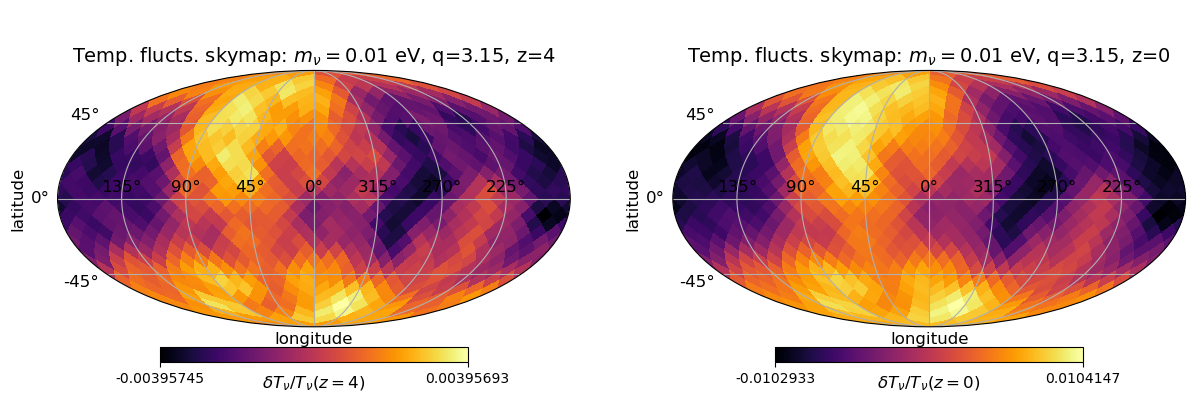

Values from Tully & Zhang (2021) Fig. 5 left for 0.05 eV and q-averaged:
-0.1762 to 0.1578 around T_CNB


In [2]:
# Choose a neutrino mass to display
m_Cl = 0.01

# Load Cl
# Cl_folder = f"Shared/Cls"  # in the end it should be this folder
Cl_folder = f"Cls"
Cls_z4 = jnp.load(f"{Cl_folder}/Cls_z=4_m={m_Cl}eV.npy")
Cls_z0 = jnp.load(f"{Cl_folder}/Cls_z=0_m={m_Cl}eV.npy")
# (q momentum bins, l multipoles) = (50, 20)

# Add the monopole term as 0 and choose a momentum to display
Cl_qi_z4 = jnp.insert(Cls_z4, 0, 0, axis=1)[Primordial.Cl_qi, :]
Cl_qi_z0 = jnp.insert(Cls_z0, 0, 0, axis=1)[Primordial.Cl_qi, :]
# (q momentum bins, l multipoles + 1) = (50, 21)

# Create temp. flucts. skymaps from Cls, fixed with a seed
np.random.seed(5)
Tmap_z4 = hp.sphtfunc.synfast(Cl_qi_z4, nside=Nside, lmax=None, pol=False)
np.random.seed(5)  #note: seed needs to reset
Tmap_z0 = hp.sphtfunc.synfast(Cl_qi_z0, nside=Nside, lmax=None, pol=False)

# Tmaps are in micro Kelvin around T_CNB, show in Kelvin
Deltas_z4 = Tmap_z4*Primordial.uK/Params.K
Deltas_z0 = Tmap_z0*Primordial.uK/Params.K
# (Npix)

dict_z4 = dict(
    title=fr"Temp. flucts. skymap: $m_\nu={m_Cl}$ eV, q={Primordial.q_select}, z=4", 
    unit=r"$\delta T_\nu / T_\nu (z=4)$",
    cmap="inferno",
    # cmap="coolwarm",
    sub=121)

dict_z0 = dict(
    title=fr"Temp. flucts. skymap: $m_\nu={m_Cl}$ eV, q={Primordial.q_select}, z=0", 
    unit=r"$\delta T_\nu / T_\nu (z=0)$",
    cmap="inferno",
    # cmap="coolwarm",
    sub=122)

SimPlot.healpix_side_by_side(
    Deltas_z4, Deltas_z0, dict_z4, dict_z0, 
    f"{fig_path}/Temp_flucts_skymaps.pdf", Params)


print(f"Values from Tully & Zhang (2021) Fig. 5 left for 0.05 eV and q-averaged:")
TZ_val_left = -176166*Primordial.uK
TZ_val_right = 157773*Primordial.uK
print(f"{TZ_val_left/Params.K:.4f} to {TZ_val_right/Params.K:.4f} around T_CNB")

## Inspect files

In [3]:
# Fermi-Dirac distribution assumption
# note: total densities are computed for length 50 mass range
pix_dens_FD = jnp.load(f"{sim_folder}/pixel_densities.npy")
tot_dens_FD = jnp.load(f"{sim_folder}/total_densities.npy")
ic(pix_dens_FD.shape)
ic(tot_dens_FD.shape)
print("\n")

# Incl. primordial fluctuations
# note: all sky densities are computed for 5 specific masses
Deltas = jnp.load(f"{sim_folder}/Deltas_halos.npy")
pix_dens_PF = jnp.load(f"{sim_folder}/pixel_densities_incl_PFs.npy")
tot_dens_PF = jnp.load(f"{sim_folder}/total_densities_incl_PFs.npy")
ic(Deltas.shape)
ic(pix_dens_PF.shape)
ic(tot_dens_PF.shape)
print("END")

ic| pix_dens_FD.shape: (10, 50, 768)
ic| tot_dens_FD.shape: (10, 50)
ic| Deltas.

shape: (10, 2, 768, 1000)
ic| pix_dens_PF.shape: (10, 2, 768)
ic| tot_dens_PF.shape: (10, 2)


END


## Compare skymaps

In [4]:
# Choose a halo and mass to display
halo_i = 1
m_specs = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
m_pick = 0.01
mPF_i = jnp.abs(m_specs - m_pick).argmin()
mFD_i = jnp.abs(m_range - m_pick).argmin()

N0_pix = Params.N0/Npix

# pix_dens_PF[halo_i, mPF_i, :]

ic| FD_skymap.sum()*N0_pix/(Params.cm**-3): Array(56.61525625, dtype=float64)
ic| PF_skymap.sum()*N0_pix/(Params.cm**-3): Array(56.61358764, dtype=float64)
/home/fabian/anaconda3/envs/dev/lib/python3.12/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': 0, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/fabian/anaconda3/envs/dev/lib/python3.12/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': 0, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")
/home/fabian/anaconda3/envs/dev/lib/python3.12/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot prope

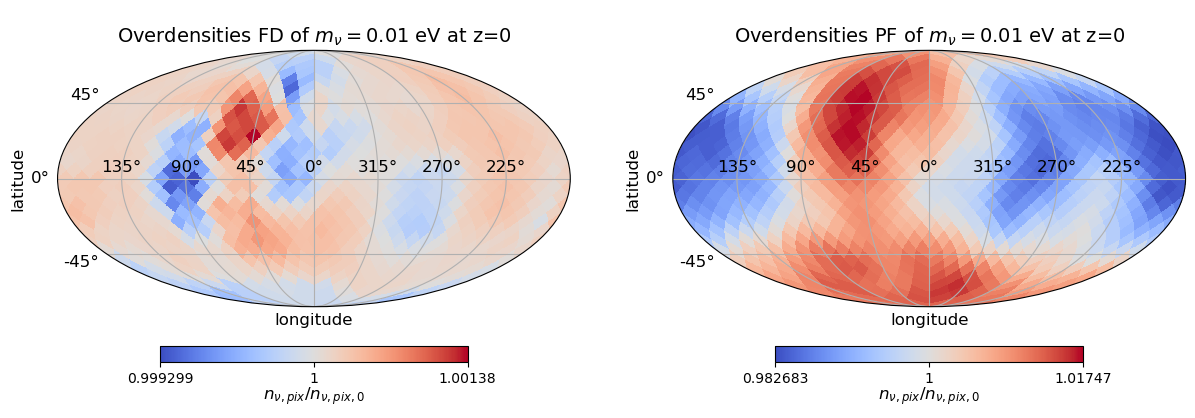

In [5]:
### ------------------------------------------- ###
### Plot parameters for Fermi-Dirac (FD) skymap ###
### ------------------------------------------- ###

FD_skymap = pix_dens_FD[halo_i, mFD_i, :] / N0_pix * (Params.cm**-3)
ic(FD_skymap.sum()*N0_pix/(Params.cm**-3))

# Make center value to be 1 (no overdensity).
mid_FD = 1.
divnorm_FD = mcolors.TwoSlopeNorm(vcenter=mid_FD)

# Plot style healpy dictionary for left skymap
dict_FD = dict(
    title=fr"Overdensities FD of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(FD_skymap), mid_FD, np.max(FD_skymap)],
    norm=divnorm_FD,
    sub=121)


### ------------------------------------------------------- ###
### Plot parameters for Primordial Fluctuations (FD) skymap ###
### ------------------------------------------------------- ###

#? do the pixel values have to be normalized differently now?
#? shouldn't there be a unique value for each pixel, since it got altered from
#? the usual LambdaCDM value of 56/cm^3 due to the primordial fluctuations?

PF_skymap = pix_dens_PF[halo_i, mPF_i, :] / N0_pix * (Params.cm**-3)
ic(PF_skymap.sum()*N0_pix/(Params.cm**-3))

# Make center value to be 1 (no overdensity).
mid_PF = 1.
divnorm_PF = mcolors.TwoSlopeNorm(vcenter=mid_PF)

# Plot style healpy dictionary for right skymap
dict_PF = dict(
    title=fr"Overdensities PF of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_PF,
    sub=122)


### ------------ ###
### Plot skymaps ###
### ------------ ###

SimPlot.healpix_side_by_side(
    map_left=FD_skymap,
    map_right=PF_skymap,
    dict_left=dict_FD,
    dict_right=dict_PF,
    fig_path=fig_path,
    args=Params)  

## Compare power spectra bands

In [12]:
Params.Pi/jnp.sqrt(pix_sr)

Array(24.55984099, dtype=float64, weak_type=True)

<>:73: SyntaxWarning: invalid escape sequence '\e'
<>:75: SyntaxWarning: invalid escape sequence '\e'
<>:73: SyntaxWarning: invalid escape sequence '\e'
<>:75: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2332894/1158204728.py:73: SyntaxWarning: invalid escape sequence '\e'
  ax1.set_xlabel("$\ell$")
/tmp/ipykernel_2332894/1158204728.py:75: SyntaxWarning: invalid escape sequence '\e'
  ax1.set_ylabel("$\ell(\ell+1)C_{\ell} [\mu K^2]$")


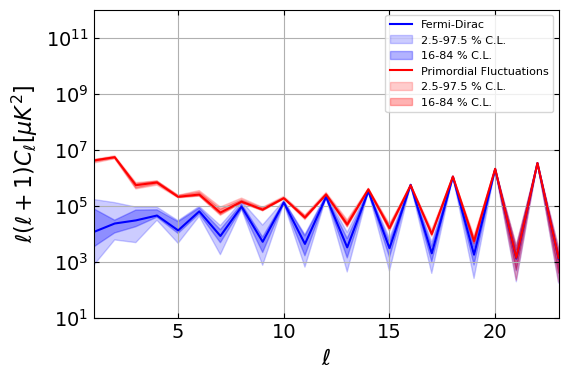

In [14]:
power_spectra_FD_l = []
power_spectra_PF_l = []
for halo_i in range(halo_num):

    FD_skymap = pix_dens_FD[halo_i, mFD_i]
    PF_skymap = pix_dens_PF[halo_i, mPF_i]

    # Convert maps of neutrino densities to temperatures.
    FD_Tmap = np.cbrt((FD_skymap * 2*Params.Pi**2) / (3 * zeta(3)))
    PF_Tmap = np.cbrt((PF_skymap * 2*Params.Pi**2) / (3 * zeta(3)))

    # Unit to compare to similar figures in literature.
    scaling = 1e12

    # Compute power spectrum of number density all-sky map.
    cl_FD = hp.sphtfunc.anafast(FD_Tmap)
    cl_PF = hp.sphtfunc.anafast(PF_Tmap)

    ell = jnp.arange(len(cl_FD))
    
    # power_spectrum_PF = ell * (ell+1) * cl_PF / (2*Params.Pi) * scaling
    # power_spectrum_FD = ell * (ell+1) * cl_FD / (2*Params.Pi) * scaling
    power_spectrum_PF = ell * (ell+1) * cl_PF / (2*Params.Pi) * scaling
    power_spectrum_FD = ell * (ell+1) * cl_FD / (2*Params.Pi) * scaling
    # power_spectrum_PF = (ell+1) * cl_PF / (2*Params.Pi) * scaling
    # power_spectrum_FD = (ell+1) * cl_FD / (2*Params.Pi) * scaling
    
    power_spectra_FD_l.append(power_spectrum_FD)
    power_spectra_PF_l.append(power_spectrum_PF)


# Convert lists to arrays
power_spectra_FD = jnp.array(power_spectra_FD_l)
power_spectra_PF = jnp.array(power_spectra_PF_l)

# Compute median and percentile ranges for Fermi-Dirac spectra
power_median_FD = jnp.median(power_spectra_FD, axis=0)
power_perc2p5_FD = jnp.percentile(power_spectra_FD, q=2.5, axis=0)
power_perc97p5_FD = jnp.percentile(power_spectra_FD, q=97.5, axis=0)
power_perc16_FD = jnp.percentile(power_spectra_FD, q=16, axis=0)
power_perc84_FD = jnp.percentile(power_spectra_FD, q=84, axis=0)

# Compute median and percentile ranges for Primordial Fluctuations spectra
power_median_PF = jnp.median(power_spectra_PF, axis=0)
power_perc2p5_PF = jnp.percentile(power_spectra_PF, q=2.5, axis=0)
power_perc97p5_PF = jnp.percentile(power_spectra_PF, q=97.5, axis=0)
power_perc16_PF = jnp.percentile(power_spectra_PF, q=16, axis=0)
power_perc84_PF = jnp.percentile(power_spectra_PF, q=84, axis=0)


fig = plt.figure(figsize =(6, 4))
fig.tight_layout()
ax1 = fig.add_subplot(111)

ax1.semilogy(
    ell, power_median_FD, color='blue', 
    label='Fermi-Dirac')
ax1.fill_between(
    ell, power_perc2p5_FD, power_perc97p5_FD, 
    color='blue', alpha=0.2, label='2.5-97.5 % C.L.')
ax1.fill_between(
    ell, power_perc16_FD, power_perc84_FD, 
    color='blue', alpha=0.3, label='16-84 % C.L.')

ax1.semilogy(
    ell, power_median_PF, color='red', 
    label='Primordial Fluctuations')
ax1.fill_between(
    ell, power_perc2p5_PF, power_perc97p5_PF, 
    color='red', alpha=0.2, label='2.5-97.5 % C.L.')
ax1.fill_between(
    ell, power_perc16_PF, power_perc84_PF, 
    color='red', alpha=0.3, label='16-84 % C.L.')

ax1.set_xlabel("$\ell$")
ax1.set_xlim(1,np.max(ell))
ax1.set_ylabel("$\ell(\ell+1)C_{\ell} [\mu K^2]$")
ax1.set_ylim(1e1, 1e12)
ax1.grid()
ax1.legend(loc='upper right', prop={'size':8})
plt.show(); plt.close()